# Droughts - Pre-Processing

In this notebook, I will be going over the preprocessing steps needed before starting the experiments. I will include the following steps:

1. Load Data
2. Select California
3. Fill NANs
4. Smoothing of the VOD signal (savgol filter)
5. Removing the climatology
6. Select drought years and non-drought years
7. Extract density cubes

## Code

In [27]:
import sys, os
cwd = os.getcwd()
sys.path.insert(0, f'{cwd}/../../')
sys.path.insert(0, '/home/emmanuel/code/py_esdc')


import xarray as xr
import pandas as pd
import numpy as np

# drought tools
from src.data.drought.loader import DataLoader
from src.features.drought.build_features import (
    get_cali_geometry,
    mask_datacube,
    smooth_vod_signal,
    remove_climatology
)
from src.visualization.drought.analysis import plot_mean_time

# esdc tools
from esdc.subset import select_pixel
from esdc.shape import ShapeFileExtract, rasterize
from esdc.transform import DensityCubes

import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
plt.style.use(['fivethirtyeight', 'seaborn-poster'])
%matplotlib inline

%load_ext autoreload
%autoreload 2

[autoreload of src.features.drought.build_features failed: Traceback (most recent call last):
  File "/home/emmanuel/.conda/envs/2019_rbig_ad/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/emmanuel/.conda/envs/2019_rbig_ad/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 434, in superreload
    module = reload(module)
  File "/home/emmanuel/.conda/envs/2019_rbig_ad/lib/python3.6/imp.py", line 315, in reload
    return importlib.reload(module)
  File "/home/emmanuel/.conda/envs/2019_rbig_ad/lib/python3.6/importlib/__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 618, in _exec
  File "<frozen importlib._bootstrap_external>", line 674, in exec_module
  File "<frozen importlib._bootstrap_external>", line 781, in get_code
  File "<frozen importlib._bootstrap_external>", line 741, in source_to_code
  File "<frozen im

ImportError: cannot import name 'remove_climatology'

## 1. Load Data

In [5]:
region = 'conus'
sampling = '14D'

drought_cube = DataLoader().load_data(region, sampling)


pixel = (-121, 37)

drought_cube

<xarray.Dataset>
Dimensions:  (lat: 461, lon: 865, time: 146)
Coordinates:
  * lat      (lat) float64 25.88 25.93 25.98 26.03 ... 48.74 48.79 48.84 48.89
  * lon      (lon) float64 -124.4 -124.3 -124.2 -124.2 ... -80.64 -80.59 -80.54
  * time     (time) datetime64[ns] 2010-06-01 2010-06-15 ... 2015-12-22
Data variables:
    SMADI    (lat, lon, time) float64 ...
    LST      (lat, lon, time) float64 ...
    NDVI     (lat, lon, time) float64 ...
    VOD      (lat, lon, time) float64 ...
    SM       (lat, lon, time) float64 ...

Verify with a simple plot.

/home/emmanuel/.conda/envs/2019_rbig_ad/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


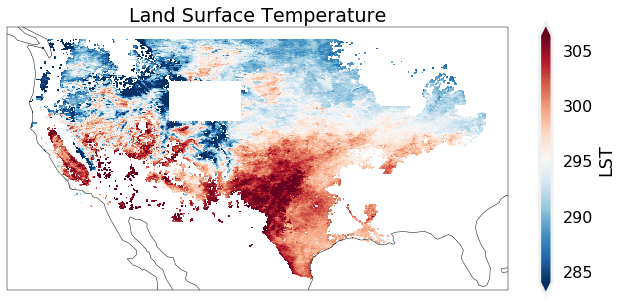

In [7]:
plot_mean_time(
    drought_cube.LST.sel(time=slice('June-2010', 'June-2010'))
)

## 2. Subset California

In [15]:
# get california polygon
cali_geoms = get_cali_geometry()

# get california cube subset
cali_cube = mask_datacube(drought_cube, cali_geoms)

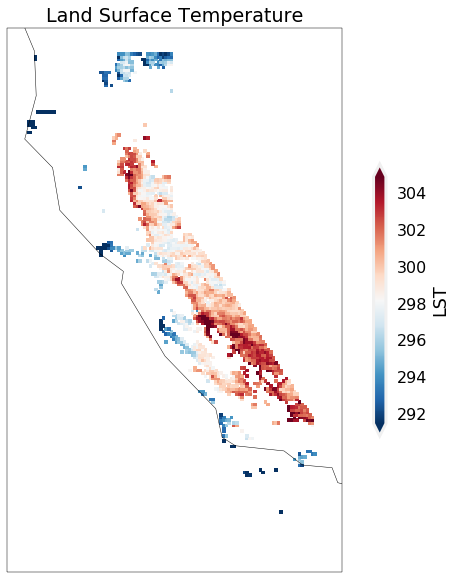

In [17]:
plot_mean_time(
    cali_cube.LST.sel(time=slice('June-2011', 'June-2011'))
)

## 3. Interpolate NANs - Time Dimension

In [22]:
# interpolation arguments
interp_dim = 'time'
method = 'linear'

# do interpolation
cali_cube_interp = cali_cube.interpolate_na(
    dim=interp_dim, 
    method=method
)

## 4. Smoothing the Signal (VOD)

In this section, we will try to smooth the signal with two methods:

1. Simple - Rolling mean
2. Using a savgol filter.

Some initial parameters:

* Window Size = 5
* Polynomial Order = 3

We will apply this filter in the time domain only.

In [11]:
vod_data = cali_cube_interp.VOD
vod_data

<xarray.DataArray 'VOD' (lat: 189, lon: 103, time: 146)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       ...,

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., n

### 4.1 - Savgol Filter

In [12]:
from scipy.signal import savgol_filter

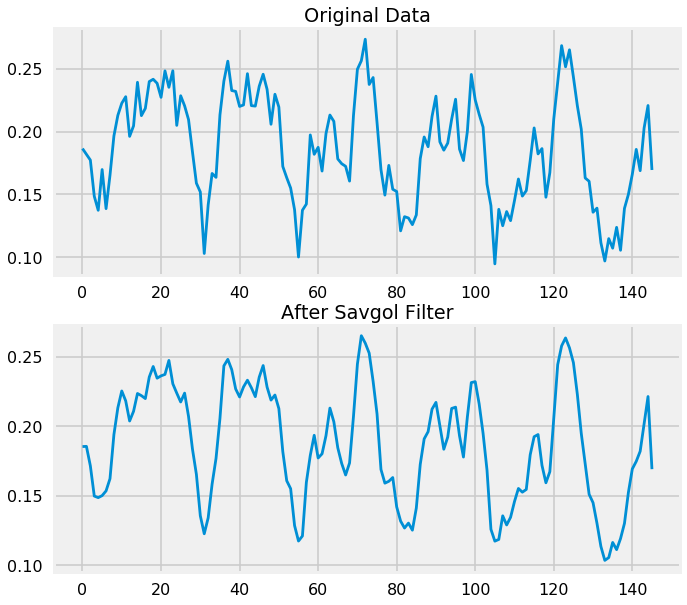

In [13]:
# select example
vod_data_ex = select_pixel(vod_data, pixel)

# savgol filter params
window_length = 5
polyorder = 3

# apply savgol filter
vod_smooth_filter = savgol_filter(
    vod_data_ex, 
    window_length=window_length, 
    polyorder=polyorder
)

fig, ax = plt.subplots(nrows=2, figsize=(10, 10))

ax[0].plot(vod_data_ex)
ax[0].set_title('Original Data')

ax[1].plot(vod_smooth_filter)
ax[1].set_title('After Savgol Filter')
plt.show()

### 4.2 - Rolling Window

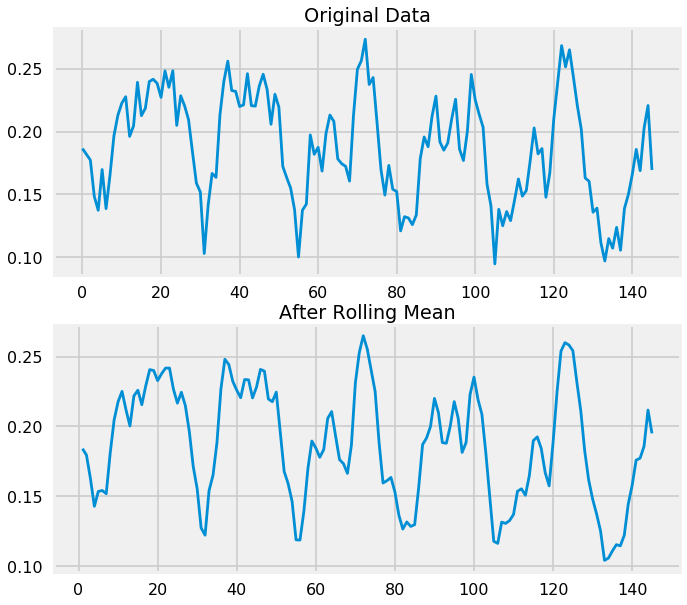

In [14]:
# select example
vod_data_ex = select_pixel(vod_data, pixel)

# savgol filter params
window_length = 2

# apply savgol filter
vod_smooth_roll = vod_data_ex.rolling(
    time=window_length, 
    center=True
).mean()

fig, ax = plt.subplots(nrows=2, figsize=(10, 10))

ax[0].plot(vod_data_ex)
ax[0].set_title('Original Data')

ax[1].plot(vod_smooth_roll)
ax[1].set_title('After Rolling Mean')
plt.show()

### 4.3 - Difference

In [15]:
vod_smooth_diff = vod_smooth_filter - vod_smooth_roll

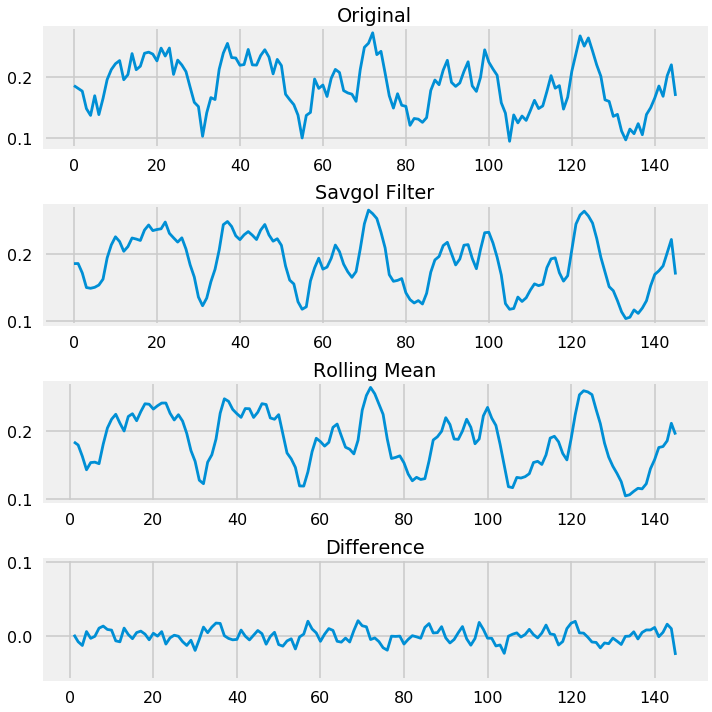

In [16]:
fig, ax = plt.subplots(nrows=4,figsize=(10,10))



ax[0].plot(vod_data_ex)
ax[0].set_title('Original')

ax[1].plot(vod_smooth_filter)
ax[1].set_title('Savgol Filter')

ax[2].plot(vod_smooth_roll)
ax[2].set_title('Rolling Mean')

ax[3].plot(vod_smooth_diff)
ax[3].set_title('Difference')

# Scale the Difference Y-Limits
ymax = np.max([vod_smooth_filter.max(), vod_smooth_roll.max()])
ymin = np.min([vod_smooth_filter.min(), vod_smooth_roll.min()])
center = (ymax - ymin)
ymax = ymax - center
ymin = center - ymin

ax[3].set_ylim([0 - ymin, 0 + ymax])

plt.tight_layout()
plt.show()

### 4.3 - Apply Rolling Mean to the whole dataset

In [26]:
cali_cube_interp = smooth_vod_signal(cali_cube_interp, window_length=2, center=True)

/home/emmanuel/.conda/envs/2019_rbig_ad/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


## 5. Remove Climatology

When I mean 'climatology', I mean the difference between observations and typical weather for a particular season. The anomalies should not show up in the seasonal cycle. I'll just do a very simple removal. I'll calculate the monthly mean wrt time and then remove that from each month from the original datacube.

**Steps**

1. Climatalogy - Monthly Mean for the 6 years
2. Remove Climatology - Climatology from each month

In [18]:


# calculate the climatology
cali_climatology_mean = calculate_monthly_mean(cali_cube_interp)

# remove climatology
cali_anomalies = cali_cube.groupby('time.month') - cali_climatology_mean

Simple check where we look at the original and the new.

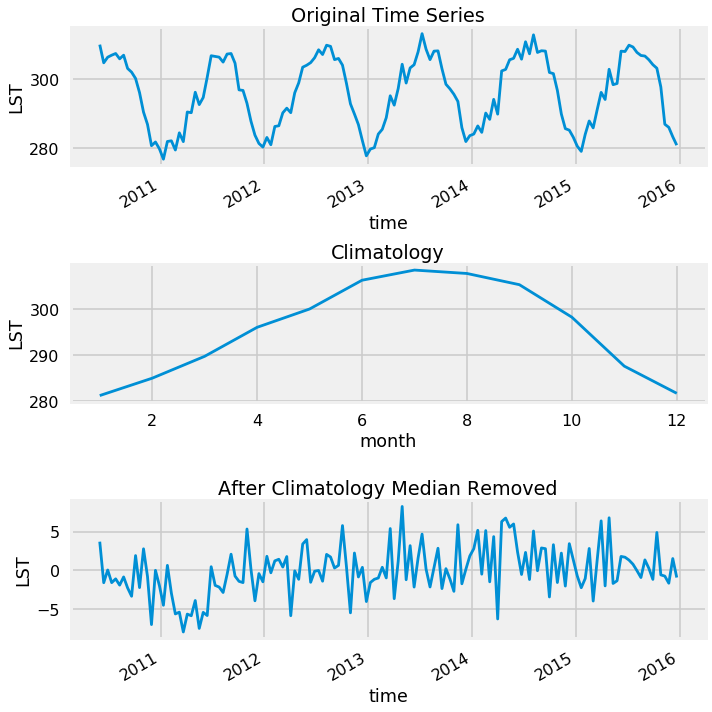

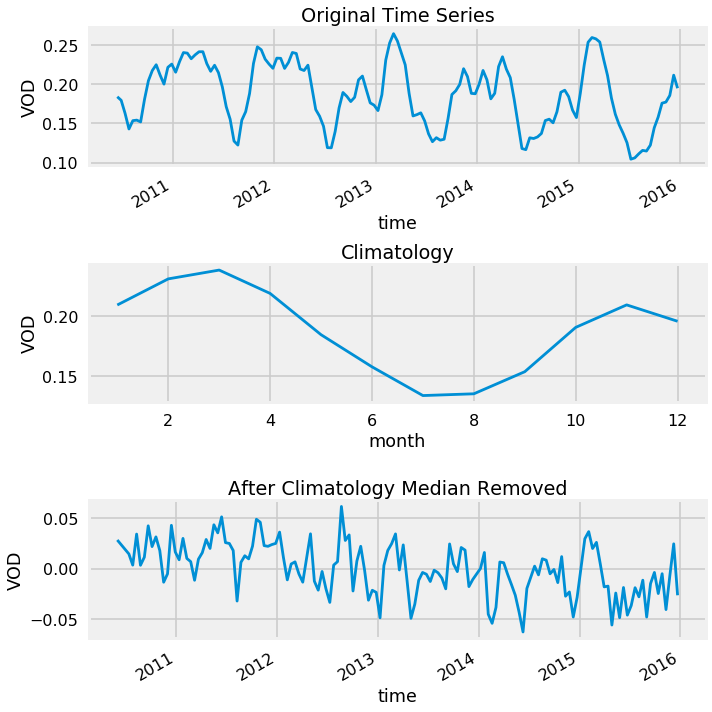

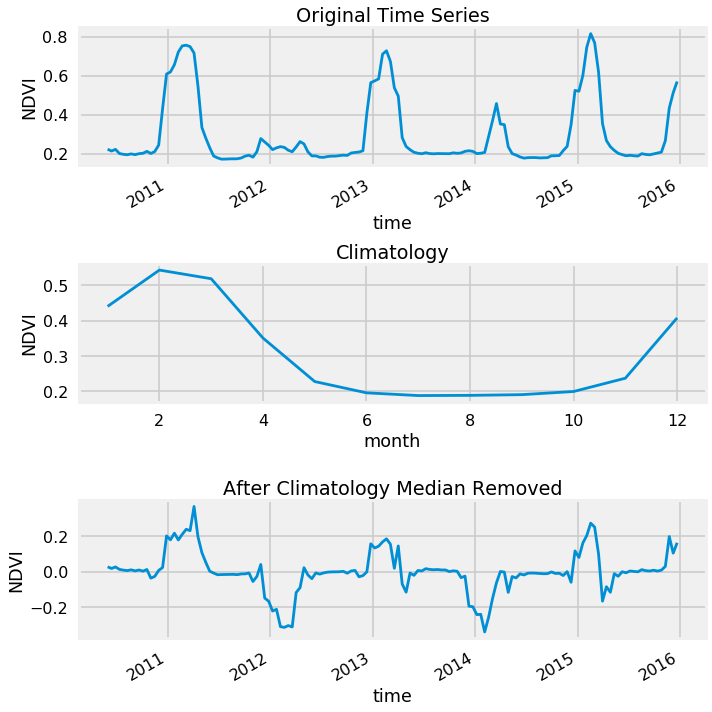

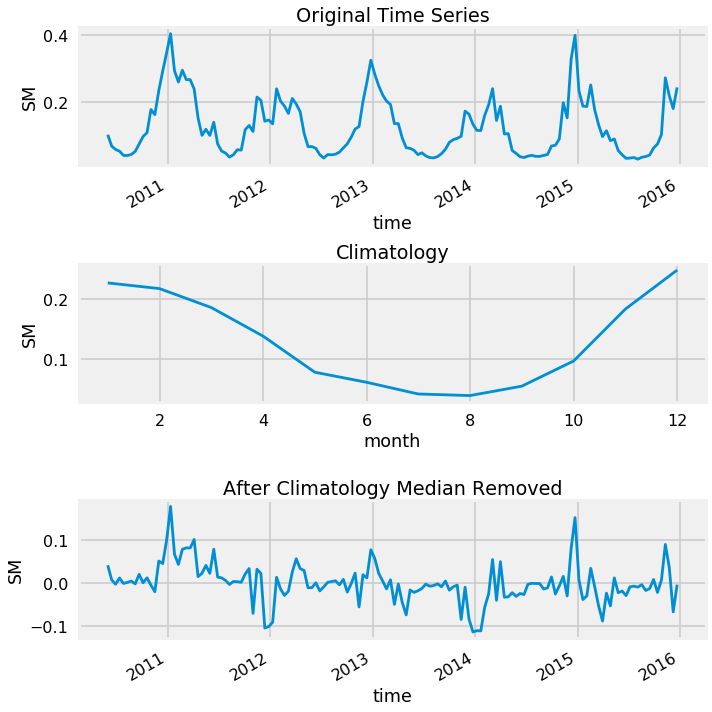

In [19]:


variables = ['LST', 'VOD', 'NDVI', 'SM']

for ivariable in variables:

    fig, ax = plt.subplots(nrows=3, figsize=(10, 10))

    # Before Climatology
    select_pixel(cali_cube_interp[ivariable], pixel).plot(ax=ax[0])
    ax[0].set_title('Original Time Series')

    # Climatology
    select_pixel(cali_climatology_mean[ivariable], pixel).plot(ax=ax[1])
    ax[1].set_title('Climatology')

    # After Climatology
    select_pixel(cali_anomalies[ivariable], pixel).plot(ax=ax[2])
    ax[2].set_title('After Climatology Median Removed')
    plt.tight_layout()
    plt.show()

## 6. EMData

I extract the dates for the drought events for california. This will allow me to separate the drought years and non-drought years.

In [20]:
!ls /media/disk/databases/SMADI/EMDAT_validation/

EMDAT_Drought_info.dbf	EMDAT_Drought_info.shx
EMDAT_Drought_info.shp	figuresStudy_regions.png


In [21]:
shape_files = '/media/disk/databases/SMADI/EMDAT_validation/'
shapefiles_clf = ShapeFileExtract()

shapefiles_clf.import_shape_files(shape_files);

In [27]:
# Extract Europe
query = 'LOCATION'
subqueries = ['California']

cali_droughts =  shapefiles_clf.extract_queries(query=query, subqueries=subqueries)

In [28]:
cali_droughts

,ID,ISO,LOCATION,Date_Start,Date_End,UTC_Start,UTC_End,geometry
105,106,USA,California,01-Jun-2012,31-Dec-2012,735021,735234,(POLYGON ((-117.2328491210938 32.7764053344726...
132,133,USA,California,01-Jan-2014,31-Dec-2014,735600,735964,(POLYGON ((-117.2328491210938 32.7764053344726...
153,154,USA,California,01-Jan-2015,31-Dec-2015,735965,736329,(POLYGON ((-117.2328491210938 32.7764053344726...


So the drought years are:

**Drought Years**

* 2012
* 2014
* 2015

**Non-Drought Years**

* 2010
* 2011
* 2013

**Note**: Even though the EM-Data says that the drought year for 2012 is only half a year, we're going to say that that is a full year.

In [29]:
# drought
cali_anomalies_drought = xr.concat([
    cali_anomalies.sel(time=slice('2012', '2012')),
    cali_anomalies.sel(time=slice('2014', '2014')),
    cali_anomalies.sel(time=slice('2015', '2015')),
], dim='time')

# non-drought
cali_anomalies_nondrought = xr.concat([
    cali_anomalies.sel(time=slice('2010', '2010')),
    cali_anomalies.sel(time=slice('2011', '2011')),
    cali_anomalies.sel(time=slice('2013', '2013')),
], dim='time')

## 7. Extract Density Cubes

In this step, we will construct 'density cubes'. These are cubes where we add features from a combination of the spatial and/or temporal dimensions. Instead of a single sample, we have a sample that takes into account spatial and/or temporal information. In this experiment, we will only look at temporal information. Our temporal resolution is 14 Days and we want to look at a maximum of 6 months.

So:

$$\Bigg\lfloor \frac{6 \: months}{\frac{14\: days}{30 \: days} \:\times 1 \: month} \Bigg\rfloor = 12 \: time \: stamps$$

In [43]:
# confirm
sub_ = cali_anomalies_drought.isel(time=slice(0,12))

sub_.time[0].data, sub_.time[-1].data

(array('2012-01-10T00:00:00.000000000', dtype='datetime64[ns]'),
 array('2012-06-12T00:00:00.000000000', dtype='datetime64[ns]'))

In [46]:
cali_anomalies.sel(time=slice('2012', '2012'))

<xarray.Dataset>
Dimensions:    (lat: 189, lon: 103, time: 26)
Coordinates:
  * lon        (lon) float64 -124.4 -124.3 -124.2 ... -118.7 -118.7 -118.6
  * lat        (lat) float64 32.53 32.58 32.63 32.68 ... 41.79 41.84 41.89 41.94
  * time       (time) datetime64[ns] 2012-01-10 2012-01-24 ... 2012-12-25
    month      (time) int64 1 1 2 2 3 3 4 4 5 5 5 ... 8 9 9 10 10 10 11 11 12 12
Data variables:
    SMADI      (lat, lon, time) float64 nan nan nan nan nan ... nan nan nan nan
    LST        (lat, lon, time) float64 nan nan nan nan nan ... nan nan nan nan
    NDVI       (lat, lon, time) float64 nan nan nan nan nan ... nan nan nan nan
    VOD        (lat, lon, time) float64 nan nan nan nan nan ... nan nan nan nan
    SM         (lat, lon, time) float64 nan nan nan nan nan ... nan nan nan nan
    cali_mask  (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan

In [55]:

l1 = ['time', 'lat', 'lon', 'depth']
l2 = ['lat', 'lon', 'time']

all([i in l1 for i in l2])

True

So we get roughly 6 months of temporal information in our density cubes.

#### 7.1 - Example Density Cube

In [92]:
# example size
spatial_window = 1
time_window = 12

# initialize datacube
minicuber = DensityCubes(
    spatial_window=spatial_window,
    time_window=time_window
)

# initialize dataframes
drought_VOD = pd.DataFrame()
drought_LST = pd.DataFrame()
drought_NDVI = pd.DataFrame()
drought_SM = pd.DataFrame()

# Group by year and get minicubes
for iyear, igroup in cali_anomalies_drought.groupby('time.year'):
    print(f"Year: {iyear}")
    # get minicubes for variables
    drought_VOD  = drought_VOD.append(minicuber.get_minicubes(igroup.VOD))
    drought_LST  = drought_LST.append(minicuber.get_minicubes(igroup.LST))
    drought_NDVI = drought_NDVI.append(minicuber.get_minicubes(igroup.NDVI))
    drought_SM   = drought_SM.append(minicuber.get_minicubes(igroup.SM))

Year: 2012
Year: 2014
Year: 2015


In [93]:
drought_VOD.shape, drought_LST.shape, drought_NDVI.shape, drought_SM.shape



((54481, 12), (85995, 12), (73771, 12), (54481, 12))